## **License Plate Detection**

**License plate recognition (LPR)** is a critical component of automated vehicle identification systems, widely employed in traffic management, law enforcement, toll collection, and parking systems. The process of LPR typically involves several stages, including license plate detection, character segmentation, and optical character recognition (OCR). Among these, character segmentation plays a pivotal role in ensuring accurate extraction of individual characters, which directly impacts the overall performance of the system.

The segmentation process focuses on isolating individual alphanumeric characters from a cropped license plate image. However, this task can be challenging due to factors such as varying lighting conditions, distortions, uneven backgrounds, and noise in the captured images. To overcome these challenges, robust preprocessing techniques and contour-based segmentation methods are essential.

In this implementation, we preprocess the license plate image to enhance its quality and apply contour-based character segmentation. By defining specific dimensions for valid contours, we filter out irrelevant shapes and extract only the desired characters. The segmented characters are then prepared for further processing, such as recognition through machine learning or OCR algorithms. This streamlined approach ensures reliable and efficient segmentation, forming the foundation for high-accuracy license plate recognition systems.

In [1]:
from google.colab import files
uploaded = files.upload()  # Opens a file dialog to upload


Saving archive (9).zip to archive (9).zip


In [2]:
import zipfile
import os

zip_path = "archive (9).zip"  # Replace with the name of your uploaded zip file
output_dir = "/content/VD"  # Replace with the desired output directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)


In [39]:
import cv2

# Path to the extracted XML file
plate_cascade_path = '/content/VD/indian_license_plate.xml'

# Load the classifier
plate_cascade = cv2.CascadeClassifier(plate_cascade_path)

# Verify if the cascade file is loaded successfully
if plate_cascade.empty():
    print("Error loading cascade file. Check the file path.")
else:
    print("Cascade file loaded successfully.")


Cascade file loaded successfully.


In [40]:
import os

# List files in the extracted folder
extracted_folder = '/content/VD/'  # Replace with your folder path
print(os.listdir(extracted_folder))


['data', 'car.jpg', 'indian_license_plate.xml']


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

This function takes an image (img) and optionally a text string (text) as inputs. It detects number plates using a plate_cascade classifier. It draws rectangles around detected plates on plate_img and can annotate the detected plate with text if text is provided. Finally, it returns the annotated image (plate_img) and the cropped region of the detected plate (plate).

In [42]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)

    return plate_img, plate # returning the processed image.

**display function:** This function takes an image (img_) and an optional title. It converts the image from BGR (OpenCV default) to RGB (for correct display in Matplotlib) and then shows the image using matplotlib.pyplot.

**image path verification:** The script checks if the image file exists at the given path. If the image is found, it is loaded using cv2.imread and displayed. If the file is not found, an error message is printed.

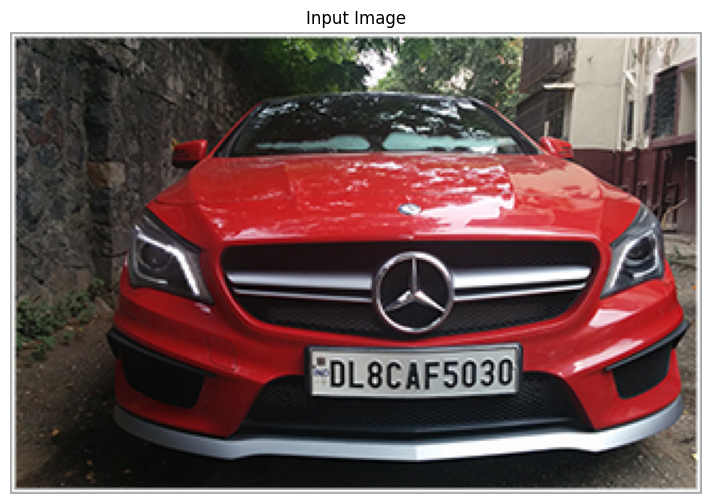

In [43]:
import cv2
import matplotlib.pyplot as plt
import os

def display(img_, title=''):
    if img_ is None:
        print("Image not loaded correctly.")
        return
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Verify image path and load
image_path = '/content/VD/car.jpg'  # Update with actual path
if os.path.exists(image_path):
    img = cv2.imread(image_path)
    display(img, 'Input Image')
else:
    print("Image file not found. Check the file path.")


In [44]:
output_img, plate = detect_plate(img)


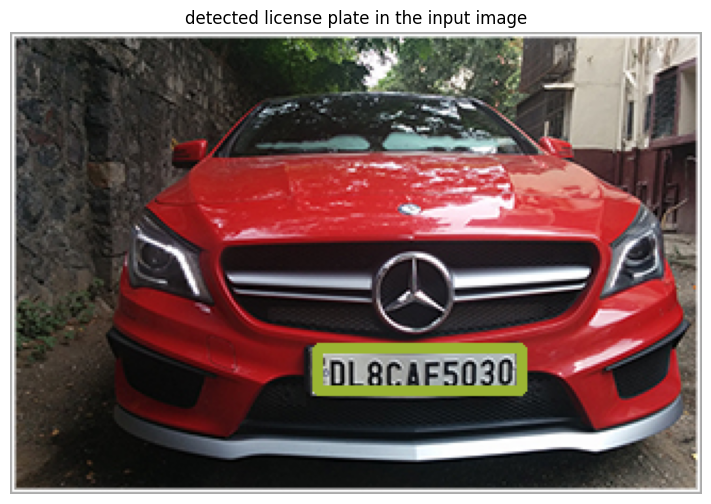

In [45]:
display(output_img, 'detected license plate in the input image')


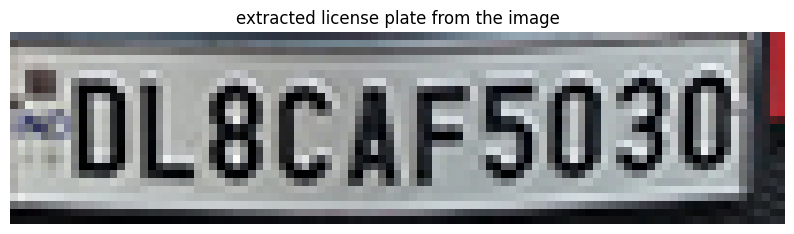

In [46]:
display(plate, 'extracted license plate from the image')

The code below does the following tasks:

- Detects and extracts contours from the image.

- Filters contours by size.

- Crops, resizes, and inverts character images for further processing.

- Sorts the character images by their x-coordinate.

In [47]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

**Preprocessing:**

- Resizes the input image to standard dimensions.
- Converts to grayscale and applies binary thresholding.
- Performs erosion and dilation for noise removal.

**Border Cleaning:**

Ensures edges of the binary image are white for consistent contour detection.

**Contour Dimensions:**

Calculates size ranges for character contours based on the license plate dimensions.

**Character Segmentation:**

Calls find_contours to extract individual characters based on filtered contours.

In [48]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

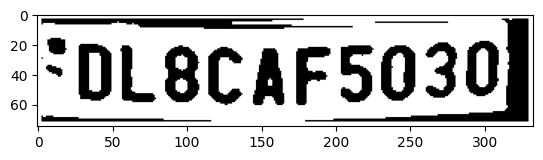

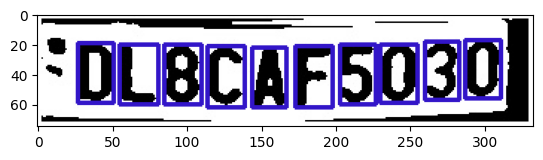

In [49]:
char = segment_characters(plate)


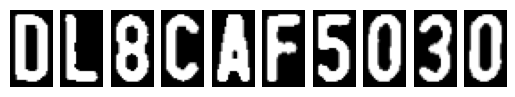

In [50]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [51]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/VD/data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [52]:
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

## Model Implementation

In [60]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
import keras.backend as K
import tensorflow as tf
import tensorflow as tf
from keras import backend as K

# Define custom F1 score metric
def custom_f1score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)  # Get the predicted class labels
    y_true = tf.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred = tf.cast(y_pred, 'float32')  # Cast y_pred to float32

    tp = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), 'float32'))  # True positives
    fp = tf.reduce_sum(tf.cast(tf.greater(y_pred, y_true), 'float32'))  # False positives
    fn = tf.reduce_sum(tf.cast(tf.less(y_pred, y_true), 'float32'))  # False negatives

    precision = tp / (tp + fp + K.epsilon())  # Precision = TP / (TP + FP)
    recall = tp / (tp + fn + K.epsilon())  # Recall = TP / (TP + FN)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1 score = 2 * (precision * recall) / (precision + recall)

    return f1



# Clear any existing session
K.clear_session()

# Define the model
model = Sequential()
model.add(Conv2D(16, (22, 22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16, 16), activation='relu', padding='same'))
model.add(Conv2D(64, (8, 8), activation='relu', padding='same'))
model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=[custom_f1score]  # Replace with custom_f1score if defined
)

# Define the stop_training_callback
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_accuracy = logs.get('val_accuracy')  # Use 'val_accuracy' if you're monitoring accuracy
        if val_accuracy is not None and val_accuracy > 0.99:
            self.model.stop_training = True

# Set batch size and callbacks
batch_size = 1
callbacks = [stop_training_callback()]

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    epochs=40,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/40
864/864 ━━━━━━━━━━━━━━━━━━━━ 78s 88ms/step - custom_f1score: 0.0543 - loss: 3.4903 - val_custom_f1score: 0.5719 - val_loss: 2.0399
Epoch 2/40


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_f1score: 0.0000e+00 - loss: 0.0000e+00 - val_custom_f1score: 0.5576 - val_loss: 2.0988
Epoch 3/40
864/864 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - custom_f1score: 0.4305 - loss: 1.9048 - val_custom_f1score: 0.8636 - val_loss: 0.8423
Epoch 4/40
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_f1score: 0.0000e+00 - loss: 0.0000e+00 - val_custom_f1score: 0.8361 - val_loss: 0.8515
Epoch 5/40
864/864 ━━━━━━━━━━━━━━━━━━━━ 78s 90ms/step - custom_f1score: 0.7257 - loss: 0.8753 - val_custom_f1score: 0.9183 - val_loss: 0.4379
Epoch 6/40
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_f1score: 0.0000e+00 - loss: 0.0000e+00 - val_custom_f1score: 0.9076 - val_loss: 0.4797
Epoch 7/40
864/864 ━━━━━━━━━━━━━━━━━━━━ 79s 90ms/step - custom_f1score: 0.8201 - loss: 0.5282 - val_custom_f1score: 0.9344 - val_loss: 0.3119
Epoch 8/40
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_f1score: 0.0000e+00 - loss: 0.0000e+00 - val_custom_f1score: 0.9593 - val_loss: 

# Testing on image

In [62]:
import numpy as np
import cv2

# Fix image dimension for model input
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

# Function to predict characters from the image
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # Iterate over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)  # Resize image
        img = fix_dimension(img_)  # Fix the dimension of the image
        img = img.reshape(1, 28, 28, 3)  # Preparing image for the model
        y_ = np.argmax(model.predict(img), axis=-1)[0]  # Predict class using predict and np.argmax
        character = dic[y_]  # Map to corresponding character
        output.append(character)  # Store the result in a list

    plate_number = ''.join(output)  # Join characters to form the plate number
    return plate_number

# Print the result
print(show_results())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
DL8CAF5030


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1

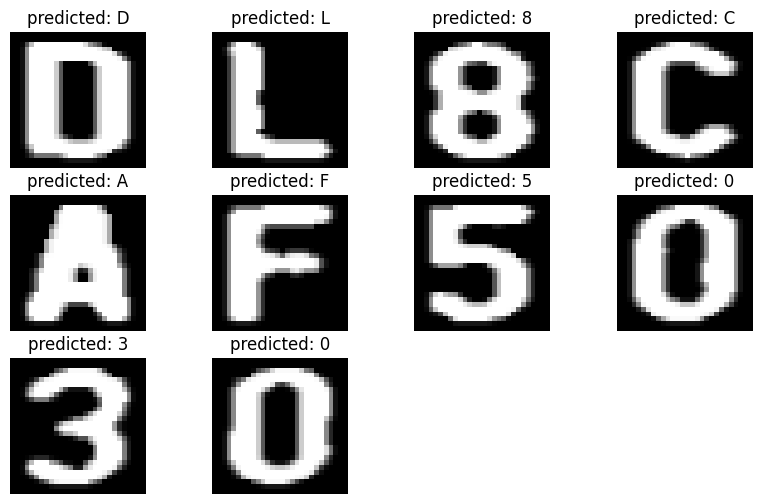

In [63]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()